# **Multi-Class Classification**

## **Preparing the DataSet**

- [`make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

**Creating a toy Multi-Class Classification dataset**

In [1]:
# Importing the dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Setting the hyper-parameters for data creation
NUM_SAMPLES =1000
NUM_FEATURES = 2
NUM_CLASSES = 4
RANDOM_SEED = 42

# 1. Create the Multi-Class dataset
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,   #how spread out or compact the data points within each cluster are
                            random_state=RANDOM_SEED

)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)
print("X_blob: ", X_blob[:5], "\n")
print("y_blob: ", y_blob[:5])

# 3. Split the data into train-test split
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)





X_blob:  tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) 

y_blob:  tensor([3., 2., 2., 1., 1.])


In [2]:
print(f"Shape: {X_train.shape, X_test.shape, y_train.shape, y_test.shape}")
print(torch.unique(y_blob))

Shape: (torch.Size([800, 2]), torch.Size([200, 2]), torch.Size([800]), torch.Size([200]))
tensor([0., 1., 2., 3.])


## **Ploting dataset**

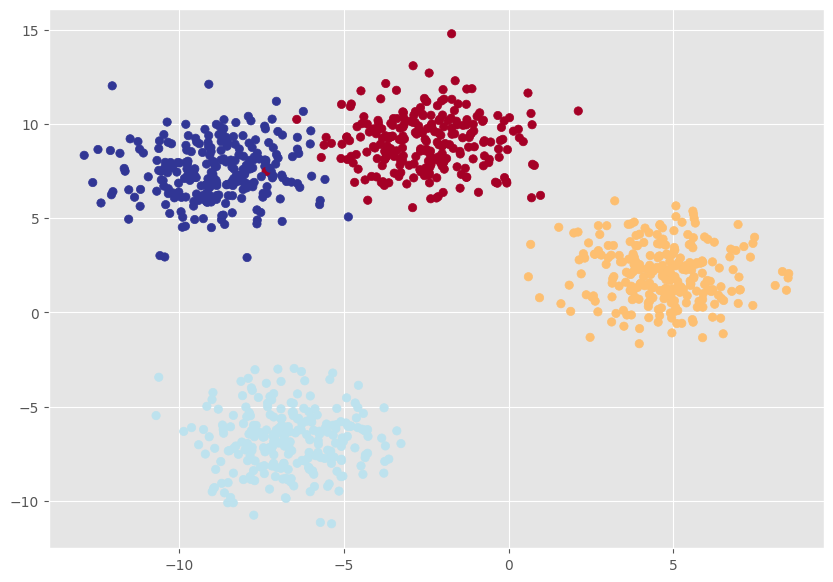

In [3]:
# 4. Plot the data
plt.style.use("ggplot")
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu); #Cmap~ viridis, inferno

## **Model**

In [4]:
from torch import nn

# Create the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_unit):
        super().__init__()
        # Define the layers in the model
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_unit),
            # Uncomment the following lines to add non-linear activation (e.g., ReLU) layers
            # nn.ReLU(),
            nn.Linear(in_features=hidden_unit, out_features=hidden_unit),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_unit, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of the BlobModel and send it to the target device
model = BlobModel(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_unit=8).to(device)

# Print the model architecture
print(model)

# Create the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

# Create an accuracy function to evaluate the model performance
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [5]:
# Print the shape of training data (X_train) and the first 5 labels (y_train)
print("Shape of training data (X_train):", X_train.shape)
print("First 5 labels (y_train):", y_train[:5])

# Print the unique elements in y_blob using PyTorch's unique function
print("Unique elements in y_blob:", torch.unique(y_blob))
print("Unique elements in y_train:", torch.unique(y_train))

# Print the shape of a single prediction sample and the total number of classes
print("Shape of a single prediction sample:", model(X_train.to(device))[0].shape)
print("Total number of classes:", NUM_CLASSES)

Shape of training data (X_train): torch.Size([800, 2])
First 5 labels (y_train): tensor([1., 0., 2., 2., 0.])
Unique elements in y_blob: tensor([0., 1., 2., 3.])
Unique elements in y_train: tensor([0., 1., 2., 3.])
Shape of a single prediction sample: torch.Size([4])
Total number of classes: 4


## **Getting Prediction probabilites** - Untrained Model

- `y_logits` $\rightarrow$ `y_pred_probs` $\rightarrow$ `y_pred_labels`


**Binary Classification**

- **Model Output ~ (Raw logits)** to $\rightarrow$ **prediction `probabilities`(Using Sigmoid/Softmax) to** $\rightarrow$ **prediction `labels`(by `torch.round()`/`argmax()`)**

```python
# Forward pass to get raw logits
y_logits = model_0(X_train).squeeze()

# Convert logits to probabilities using sigmoid function
y_pred_probs = torch.sigmoid(y_logits)

# Round probabilities to get binary predictions
y_pred = torch.round(y_pred_probs)
```
<br></br>

**Multiclass Classification**

**Logits** (raw output of the model) $\rightarrow$ **Pred probs** (use torch.softmax) $\rightarrow$ **Pred labels** (take the argmax of the prediction probabilities)

```python
# Forward pass to get raw logits
y_logits = model(X_test.to(device))

# Apply softmax to get class probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Get the predicted class (class with the highest probability)
y_pred = y_pred_probs.argmax(dim=1)

```

**Checking model predictions without training**

In [6]:
# Make prediction logits with the untrained model
y_logits = model(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Get the predicted class by selecting the index with the highest probability
y_pred = torch.argmax(y_pred_probs, dim=1)

# Print the first 5 samples of y_logits, y_pred_probs, and y_pred
print("First 5 samples of y_logits:")
print(y_logits[:5])
print("\n")

print("First 5 samples of y_pred_probs:")
print(y_pred_probs[:5])
print("\n")

print("First 5 samples of y_pred:")
print(y_pred[:5])
print("\n")

# Check which class is most likely for the first sample
print("Probabilities for the first sample:")
print(y_pred_probs[0])
print("Predicted class for the first sample:")
print(y_pred[0].item())

First 5 samples of y_logits:
tensor([[-0.4322,  0.5435,  0.1430,  0.6023],
        [ 1.4247, -0.7474, -2.5266,  0.8451],
        [ 0.0532, -1.0320, -0.2934, -2.0115],
        [-0.5596,  0.3317,  0.3895, -0.0640],
        [ 0.6433,  0.2055, -1.4898,  1.6288]], grad_fn=<SliceBackward0>)


First 5 samples of y_pred_probs:
tensor([[0.1213, 0.3218, 0.2156, 0.3413],
        [0.5906, 0.0673, 0.0114, 0.3308],
        [0.4604, 0.1556, 0.3256, 0.0584],
        [0.1305, 0.3182, 0.3371, 0.2142],
        [0.2251, 0.1453, 0.0267, 0.6030]], grad_fn=<SliceBackward0>)


First 5 samples of y_pred:
tensor([3, 0, 0, 2, 3])


Probabilities for the first sample:
tensor([0.1213, 0.3218, 0.2156, 0.3413], grad_fn=<SelectBackward0>)
Predicted class for the first sample:
3


**Note:** `indices = torch.argmax(y_pred, dim=1)` and `indices = y_pred.argmax(dim=1)` both compute the indices of the maximum values along dimension 1 of `y_pred`.


- You can see the output of `torch.argmax()` returns `2`, so for the features (`X`) of the sample at index 0, the model is predicting that the most likely class value (`y`) is `2`.

- Of course, right now this is just random guessing so it's got a `25%` chance of being right (since there's **four classes**).

- But we can improve those chances by training the model.

> The index of the value with the highest **prediction probability** is the **class number** the model thinks is *most* likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

In [7]:
# checking the sum of probablity
print(y_pred_probs[0].sum().item())
print(torch.sum(y_pred_probs[0])) #`.itel()` to get the item inside the tensor

1.0
tensor(1., grad_fn=<SumBackward0>)


In [8]:
torch.unique(y_pred)

tensor([0, 1, 2, 3])

In [9]:
# Print the ground truth labels (y_test)
print("Ground Truth Labels (y_test):")
print(y_test)
print("\n")

# Print the predicted labels (y_pred)
print("Predicted Labels (y_pred):")
print(y_pred)
print("\n")

print(accuracy_fn(y_true=y_test, y_pred=y_pred))

Ground Truth Labels (y_test):
tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])


Predicted Labels (y_pred):
tensor([3, 0, 0, 2, 3, 0, 2, 3, 0, 3, 3, 3, 

In [10]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mohd-faizy/PyTorch-Essentials/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

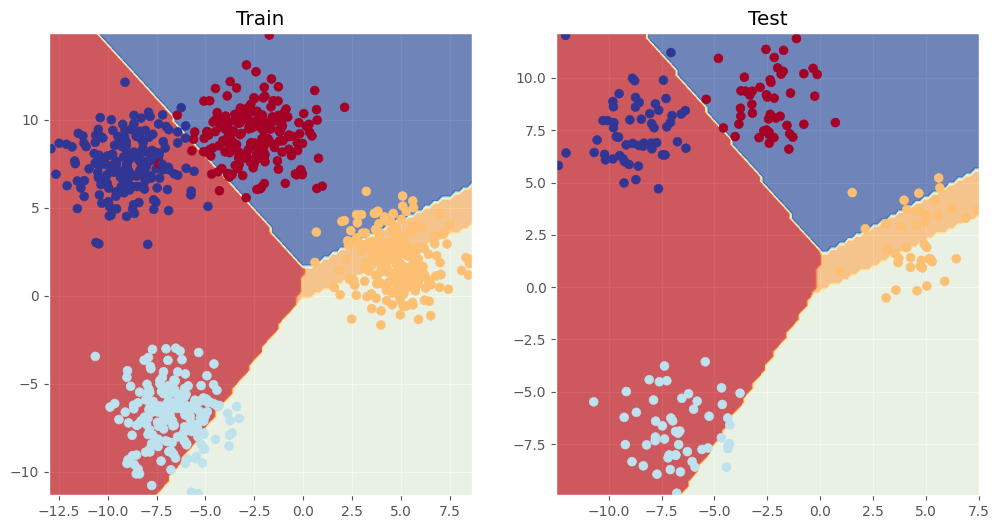

In [11]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## **Creating Training and test loop**

Epoch: 0 | loss: 1.20366 | Acc: 11.88 | Test Loss: 1.07336 | Test Acc: 26.00
Epoch: 10 | loss: 0.59812 | Acc: 78.00 | Test Loss: 0.56467 | Test Acc: 80.50
Epoch: 20 | loss: 0.42768 | Acc: 97.38 | Test Loss: 0.41278 | Test Acc: 98.50
Epoch: 30 | loss: 0.34039 | Acc: 98.88 | Test Loss: 0.33222 | Test Acc: 99.00
Epoch: 40 | loss: 0.28507 | Acc: 99.00 | Test Loss: 0.27980 | Test Acc: 99.50
Epoch: 50 | loss: 0.24601 | Acc: 99.25 | Test Loss: 0.24207 | Test Acc: 99.50
Epoch: 60 | loss: 0.21662 | Acc: 99.12 | Test Loss: 0.21327 | Test Acc: 99.50
Epoch: 70 | loss: 0.19356 | Acc: 99.25 | Test Loss: 0.19043 | Test Acc: 99.50
Epoch: 80 | loss: 0.17495 | Acc: 99.38 | Test Loss: 0.17184 | Test Acc: 99.50
Epoch: 90 | loss: 0.15961 | Acc: 99.38 | Test Loss: 0.15641 | Test Acc: 99.00




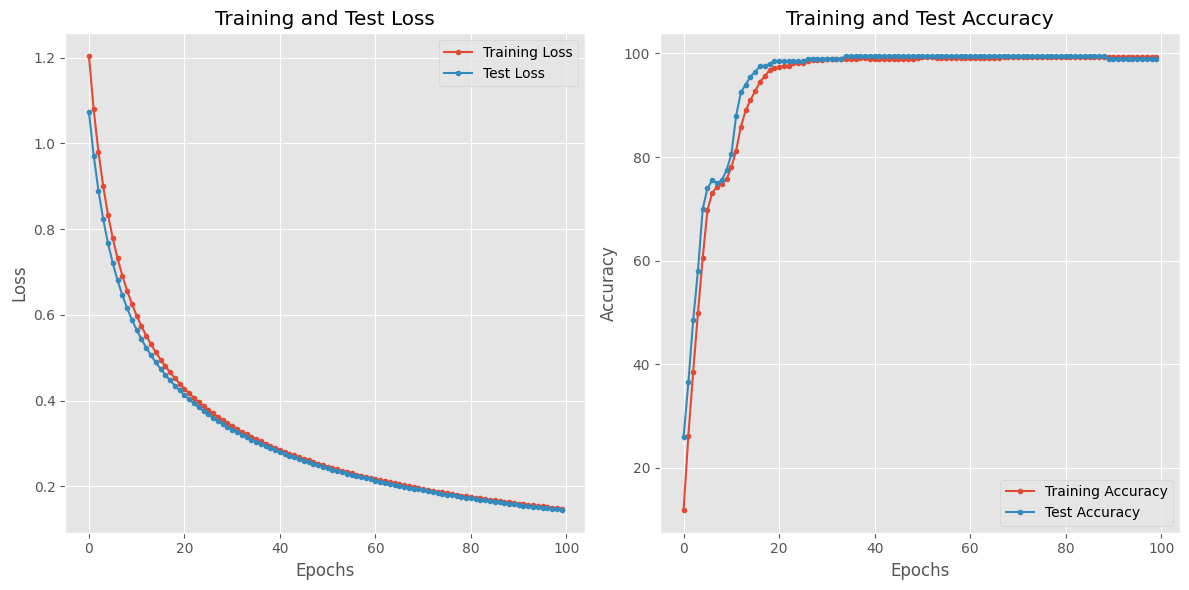

In [12]:
# Setting the random seed
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Define lists to store metrics for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Put the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Convert target variables to Long type
# CrossEntropyLoss expects the target labels to be of data type torch.long
y_train = y_train.to(torch.long)
y_test = y_test.to(torch.long)

# Loop through data
for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_train)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)

    # 2. Calculate the loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

     # Appending train loss and accuracy to the list
    train_losses.append(loss.item())
    train_accuracies.append(acc)


    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred_prob = torch.softmax(test_logits, dim=1)
        test_pred = torch.argmax(test_pred_prob, dim=1)

        # 2. Calculate the loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Appending test loss and  test accuracy to the list
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)


    # Training progress report/model evaluation summary
    # Print out what's happening after 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

print("\n")

# Plotting training and testing metrics
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss", marker='.')
plt.plot(range(epochs), test_losses, label="Test Loss", marker='.')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy", marker=".")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker=".")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

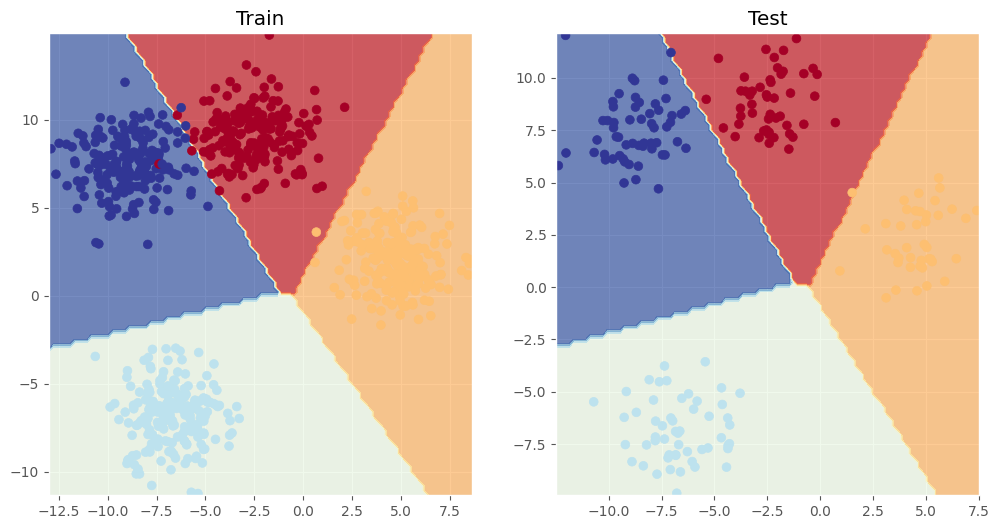

In [13]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)